In [6]:
import librosa
from sklearn.metrics import classification_report
from datasets import load_dataset

output_column = "Speaker_gender"
model_name_or_path = "./models/facebook_wav2vec2-large-slavic-voxpopuli-v2gender_2s_0/checkpoint-250"
test_dataset = load_dataset("csv", data_files={"test": "002_gender_test_for_datasets.csv"}, delimiter=",")["test"]


Using custom data configuration default-2577880023f865b3
Reusing dataset csv (/home/peterr/.cache/huggingface/datasets/csv/default-2577880023f865b3/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
from transformers import AutoConfig, Wav2Vec2Processor
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

config = AutoConfig.from_pretrained(model_name_or_path)

try:
    processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
except:
    from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor
    tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(
        "./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token=" "
    )
    feature_extractor = Wav2Vec2FeatureExtractor(
        feature_size=1,
        sampling_rate=16000,
        padding_value=0.0,
        do_normalize=True,
        return_attention_mask=True,
    )
    processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

/home/peterr/anaconda3/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:52: FutureWarning: Loading a tokenizer inside Wav2Vec2Processor from a config that does not include a `tokenizer_class` attribute is deprecated and will be removed in v5. Please add `'tokenizer_class': 'Wav2Vec2CTCTokenizer'` attribute to either your `config.json` or `tokenizer_config.json` file to suppress this warning: 
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Device: cuda


In [8]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [9]:
import torchaudio
import numpy as np
test_dataset = test_dataset.map(speech_file_to_array_fn)

  0%|          | 0/2000 [00:00<?, ?ex/s]

In [10]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


result = test_dataset.map(predict, batched=True, batch_size=8)

  0%|          | 0/250 [00:00<?, ?ba/s]

In [11]:
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

['F', 'M']

In [12]:
y_true = [config.label2id[name] for name in result[output_column]]
y_pred = result["predicted"]

print(y_true[:5])
print(y_pred[:5])

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]


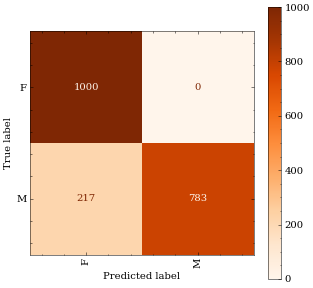

In [15]:

y_true = [name for name in result[output_column]]
y_pred = [config.id2label[name] for name in result["predicted"]]


import matplotlib.pyplot as plt
plt.style.use("science no-latex".split())
from sklearn.metrics import ConfusionMatrixDisplay
fi, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(
   y_true, y_pred, cmap="Oranges", ax=ax, xticks_rotation=90)
plt.savefig("images/003_cm_slavic_speaker_gender_2s.png")
plt.savefig("images/003_cm_slavic_speaker_gender_2s.pdf")
plt.show()



In [14]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

0.8915